### 1. Library 불러오기, SEE 설정, CUDA 사용

In [1]:
# 필요 라이브러리 import

# Pytorch
import torch
import torch.optim as optim
import torch.nn as nn

# Dataset 관련
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import sequence as sq

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns


'''
딥러닝 학습을 진행할 때, 가중치를 임의의 값으로 초기화하여 학습을 수행하는 데, 
실험을 동일하게 진행하기 위해서는 난수를 동일하게 생성해야 한다.
Pytorch에서 random seed를 고정하기 위해 manual_seed를 사용한다.
'''

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 맥북 용
# GPU 사용 가능 환경인지 확인 -> mac의 경우 GPU가 아는 MPS를 사용
print(f"mps 사용 가능 여부: {torch.backends.mps.is_available()}")
print(f"mps 지원 환경 여부: {torch.backends.mps.is_built()}")
device = torch.device("mps")

# 윈도우 용(Colab)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available')


mps 사용 가능 여부: True
mps 지원 환경 여부: True
mps is available


### 2. 데이터 불러오기 및 전처리 (Binary, Scale, Tensor, train&valid&test split)

In [39]:
# 데이터 불러오기
file_path = '../../data/' # for mac
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
df = df.iloc[:1000]
df['returns_next10m'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 종속변수 이진분류화
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬

# sequence length를 기준으로 sequence 데이터 생성
X, y = sq.create_sequence(df, seq_len=20)
# Tensor화
X = torch.FloatTensor(X).to(device)
y = torch.FloatTensor(y).to(device)
print('Full Data Size:', X.size(), y.size())

# split (60% / 20% / 20%)
train_split = int((X.size(0)) * 0.6)
valid_split = int((X.size(0)) * 0.8)

X_train_seq = X[:train_split]
X_val_seq = X[train_split:valid_split]
X_test_seq = X[valid_split:]
y_train_seq = y[:train_split]
y_val_seq = y[train_split:valid_split]
y_test_seq = y[valid_split:]

print('Train Size:', X_train_seq.size(), y_train_seq.size())
print('Valid Size:', X_val_seq.size(), y_val_seq.size())
print('Test Size:', X_test_seq.size(), y_test_seq.size())


Full Data Size: torch.Size([707, 20, 77]) torch.Size([707, 1])
Train Size: torch.Size([424, 20, 77]) torch.Size([424, 1])
Valid Size: torch.Size([141, 20, 77]) torch.Size([141, 1])
Test Size: torch.Size([142, 20, 77]) torch.Size([142, 1])


In [40]:
# Dataset과 DataLoader를 이용해 배치 데이터로 만든다.
train = torch.utils.data.TensorDataset(X_train_seq, y_train_seq)
valid = torch.utils.data.TensorDataset(X_val_seq, y_val_seq)
test = torch.utils.data.TensorDataset(X_test_seq, y_test_seq)
batch_size = 32 # 64, 128
train_loader =  torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True) # 시계열 데이터기에 shuffle X, 마지막 batch 버림
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)


### 3. 모델 정의 및 학습

In [15]:
class CNNTimeSeries(nn.Module):
    def __init__(self, num_features, num_classes):
        super(CNNTimeSeries, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 5, 512)  # 여기서 128 * 5의 계산은 컨볼루션과 풀링 과정을 거친 데이터의 차원에 따라 다를 수 있습니다.
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [14]:
# 모델 초기화
model = CNNTimeSeries(num_features=77, num_classes=1).to(device)

# 손실 함수 및 최적화
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 과정
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # 여기에서 inputs의 차원을 조정해야 할 수 있음
        inputs = inputs.permute(0, 2, 1)  # [batch_size, seq_len, num_features] -> [batch_size, num_features, seq_len]
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.7093
Epoch [2/100], Loss: 0.7067
Epoch [3/100], Loss: 0.7080
Epoch [4/100], Loss: 0.7085
Epoch [5/100], Loss: 0.7100
Epoch [6/100], Loss: 0.7277
Epoch [7/100], Loss: 0.6650
Epoch [8/100], Loss: 0.5779
Epoch [9/100], Loss: 0.4200
Epoch [10/100], Loss: 0.3242
Epoch [11/100], Loss: 0.1785
Epoch [12/100], Loss: 0.4191
Epoch [13/100], Loss: 0.1515
Epoch [14/100], Loss: 0.3688
Epoch [15/100], Loss: 0.2063
Epoch [16/100], Loss: 0.1481
Epoch [17/100], Loss: 0.1262
Epoch [18/100], Loss: 0.0795
Epoch [19/100], Loss: 0.0786
Epoch [20/100], Loss: 0.0755
Epoch [21/100], Loss: 0.1151
Epoch [22/100], Loss: 0.0607
Epoch [23/100], Loss: 0.0653
Epoch [24/100], Loss: 0.0293
Epoch [25/100], Loss: 0.0121
Epoch [26/100], Loss: 0.0091
Epoch [27/100], Loss: 0.0068
Epoch [28/100], Loss: 0.0056
Epoch [29/100], Loss: 0.0048
Epoch [30/100], Loss: 0.0041
Epoch [31/100], Loss: 0.0035
Epoch [32/100], Loss: 0.0030
Epoch [33/100], Loss: 0.0027
Epoch [34/100], Loss: 0.0024
Epoch [35/100], Loss: 0

In [43]:
from sklearn import metrics
import torch

# 테스트 데이터 로더(test_loader)에서 데이터를 반복
all_preds = []
all_targets = []

model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():  # 그라디언트 계산을 비활성화
    for inputs, targets in test_loader:
        # 데이터를 같은 디바이스로 이동
        inputs = inputs.permute(0, 2, 1).to(device)  # X_test_seq.permute(0, 2, 1)와 동일한 차원 조정

        # 모델 예측
        outputs = torch.sigmoid(model(inputs))
        preds = torch.round(outputs)
        
        # 예측 결과와 타겟을 CPU로 이동하고 NumPy 배열로 변환
        preds = preds.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        
        # 결과 저장
        all_preds.extend(preds.flatten())
        all_targets.extend(targets.flatten())

# 전체 테스트 데이터셋에 대한 정확도 계산
accuracy = metrics.accuracy_score(all_targets, all_preds)
print("Accuracy:", accuracy)


Accuracy: 0.6901408450704225


In [43]:
model.eval() # 모델을 평가 모드로 설정
test_loss = 0
with torch.no_grad(): # 기울기 계산을 비활성화하여 메모리 사용량을 줄이고 계산 속도를 높임
    for inputs, targets in test_loader:
        inputs = inputs.permute(0, 2, 1) # 차원 재정렬: [batch_size, num_features, seq_len]
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0) # 전체 손실 계산

test_loss = test_loss / len(test_loader.dataset)  # 평균 손실 계산
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.2483


In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def binary_accuracy(outputs, targets):
    """
    outputs: 모델의 예측값, 확률 또는 로짓 값으로 가정
    targets: 실제 타깃 레이블
    """
    predicted = outputs.round()  # 확률 값이 0.5 이상이면 1, 그렇지 않으면 0
    accuracy = accuracy_score(targets, predicted)
    precision = precision_score(targets, predicted)
    recall = recall_score(targets, predicted)
    f1 = f1_score(targets, predicted)
    return accuracy, precision, recall, f1


Accuracy: 0.3451, Precision: 0.3478, Recall: 0.9412, F1 Score: 0.5079


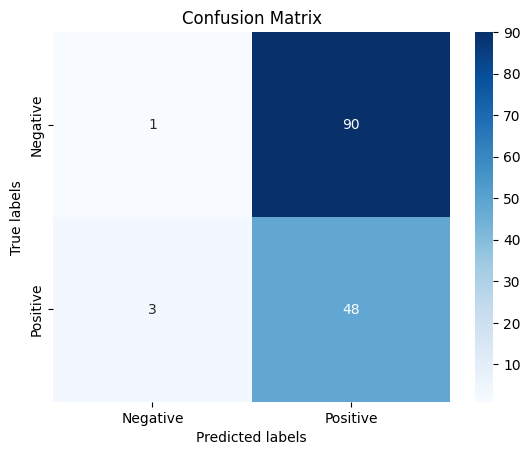

In [50]:
model = model.to('cpu')

model.eval()  # 모델을 평가 모드로 설정
all_targets = []
all_outputs = []

with torch.no_grad():  # 기울기 계산을 비활성화
    for inputs, targets in test_loader:
        inputs = inputs.permute(0, 2, 1).to('cpu')  # 차원 재정렬 및 CPU로 이동: [batch_size, num_features, seq_len]
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)  # 로짓 값을 확률로 변환
        all_targets.extend(targets.to('cpu').numpy())  # CPU로 이동 후 NumPy 배열로 변환
        all_outputs.extend(outputs.to('cpu').numpy().round())  # CPU로 이동 후 NumPy 배열로 변환 및 반올림

# 혼동 행렬 계산
cm = confusion_matrix(all_targets, all_outputs)

# 평가 지표 계산
accuracy, precision, recall, f1 = binary_accuracy(np.array(all_outputs), np.array(all_targets))
print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# 혼동 행렬 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
